In [1]:
from datetime import datetime
import pandas as pd
pd.set_option('display.max_colwidth', None)


import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

import urllib.parse
import json

import os
from tqdm import tqdm

import missingno as msno

## import helper

In [2]:
from config_GAM2025 import gam_info
from security_config import api_key

import test_functions
import functions

In [3]:
# country
country_codes = pd.read_excel(f"../../{gam_info['lookup_file']}", sheet_name='CountryID')
country_codes = country_codes.rename(columns={'ATI': 'geo_country'})

# week 
week_tester = pd.read_excel(f"../../{gam_info['lookup_file']}", sheet_name='GAM Period')
#week_tester['w/c'] = pd.to_datetime(week_tester['w/c'])

# site info - with api query
site_info = pd.read_excel(f"../../{gam_info['lookup_file']}", sheet_name='Site_API').drop(columns=['no results', 'Description'])
site_info['Report No.'] = site_info['Report No.'].astype(str)
site_info = site_info[site_info['script'] == '1_site_ingestion']
display(site_info.sample())

# platform codes
platform_codes = pd.read_excel(f"../../{gam_info['lookup_file']}", sheet_name='PlatformID')#[cols]

# service codes
service_codes = pd.read_excel(f"../../{gam_info['lookup_file']}", sheet_name='ServiceID')#[cols]
service_codes = service_codes.rename(columns={'ATI (Level 2 site)': 'site_level2'})

# language service map 
service_language_map = pd.read_excel(f"../../{gam_info['lookup_file']}", sheet_name='Site_language')

# non js 
non_js_map = pd.read_excel(f"../../{gam_info['lookup_file']}", sheet_name='Site_NonJS')

# app
app_map = pd.read_excel(f"../../{gam_info['lookup_file']}", sheet_name='Site_App')


,Category,Report No.,Space,PlatformID,ServiceID,script,application,API,api_key
72,Studios,100,BBC Studios - Syndication,WDI,WOR,1_site_ingestion,reach,"https://api.atinternet.io/v3/data/getData?param={""columns"":[""date_yearofweek"",""date_week"",""geo_country"",""m_unique_visitors""],""sort"":[""date_yearofweek"",""date_week"",""-m_unique_visitors""],""space"":{""s"":[631891,631893,642216,631894,631890,632020,632021,632014,627585,632019,631899,632015,631895,631896,631897,632016,632736,638825,637129,632271,635034,631898]},""period"":{""p1"":[{""type"":""D"",""start"":""START_DATE"",""end"":""END_DATE""}]},""max-results"":10000,""page-num"":1,""options"":{""ignore_null_properties"":true}}",studios


In [4]:
full_df = pd.read_csv(f"../data/raw/{gam_info['file_timeinfo']}_rawDataFromPiano.csv", dtype={'Report No.': str})
full_df.drop(columns=['m_page_loads', 'src', 'Description'], inplace=True)
full_df['app_name'] = full_df['app_name'].astype(str)

/var/folders/gz/pq5c3fbj5rs1tz_5w1hycq4h0000gn/T/ipykernel_19124/3920569131.py:1: DtypeWarning: Columns (7,11,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  full_df = pd.read_csv(f"../data/raw/{gam_info['file_timeinfo']}_rawDataFromPiano.csv", dtype={'Report No.': str})


In [5]:
full_df[full_df['Report No.'] == '100']

,Category,Report No.,Space,YearGAE,Week Number,w/c,site_level2,geo_country,m_unique_visitors,device_type,app_name,language,producer_nonjs
3435808,Studios,100,BBC Studios - Syndication,2025,16,2024-04-15,NaN,United states,798258.0,NaN,nan,NaN,NaN
3435809,Studios,100,BBC Studios - Syndication,2025,16,2024-04-15,NaN,United kingdom,430352.0,NaN,nan,NaN,NaN
3435810,Studios,100,BBC Studios - Syndication,2025,16,2024-04-15,NaN,Australia,158650.0,NaN,nan,NaN,NaN
3435811,Studios,100,BBC Studios - Syndication,2025,16,2024-04-15,NaN,Canada,66919.0,NaN,nan,NaN,NaN
3435812,Studios,100,BBC Studios - Syndication,2025,16,2024-04-15,NaN,Netherlands,28189.0,NaN,nan,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3447312,Studios,100,BBC Studios - Syndication,2025,33,2024-08-12,NaN,Niger,2.0,NaN,nan,NaN,NaN
3447313,Studios,100,BBC Studios - Syndication,2025,33,2024-08-12,NaN,Norfolk island,2.0,NaN,nan,NaN,NaN
3447314,Studios,100,BBC Studios - Syndication,2025,33,2024-08-12,NaN,Samoa,2.0,NaN,nan,NaN,NaN
3447315,Studios,100,BBC Studios - Syndication,2025,33,2024-08-12,NaN,Sao tome and principe,2.0,NaN,nan,NaN,NaN


## setup for platform processing

<Axes: >

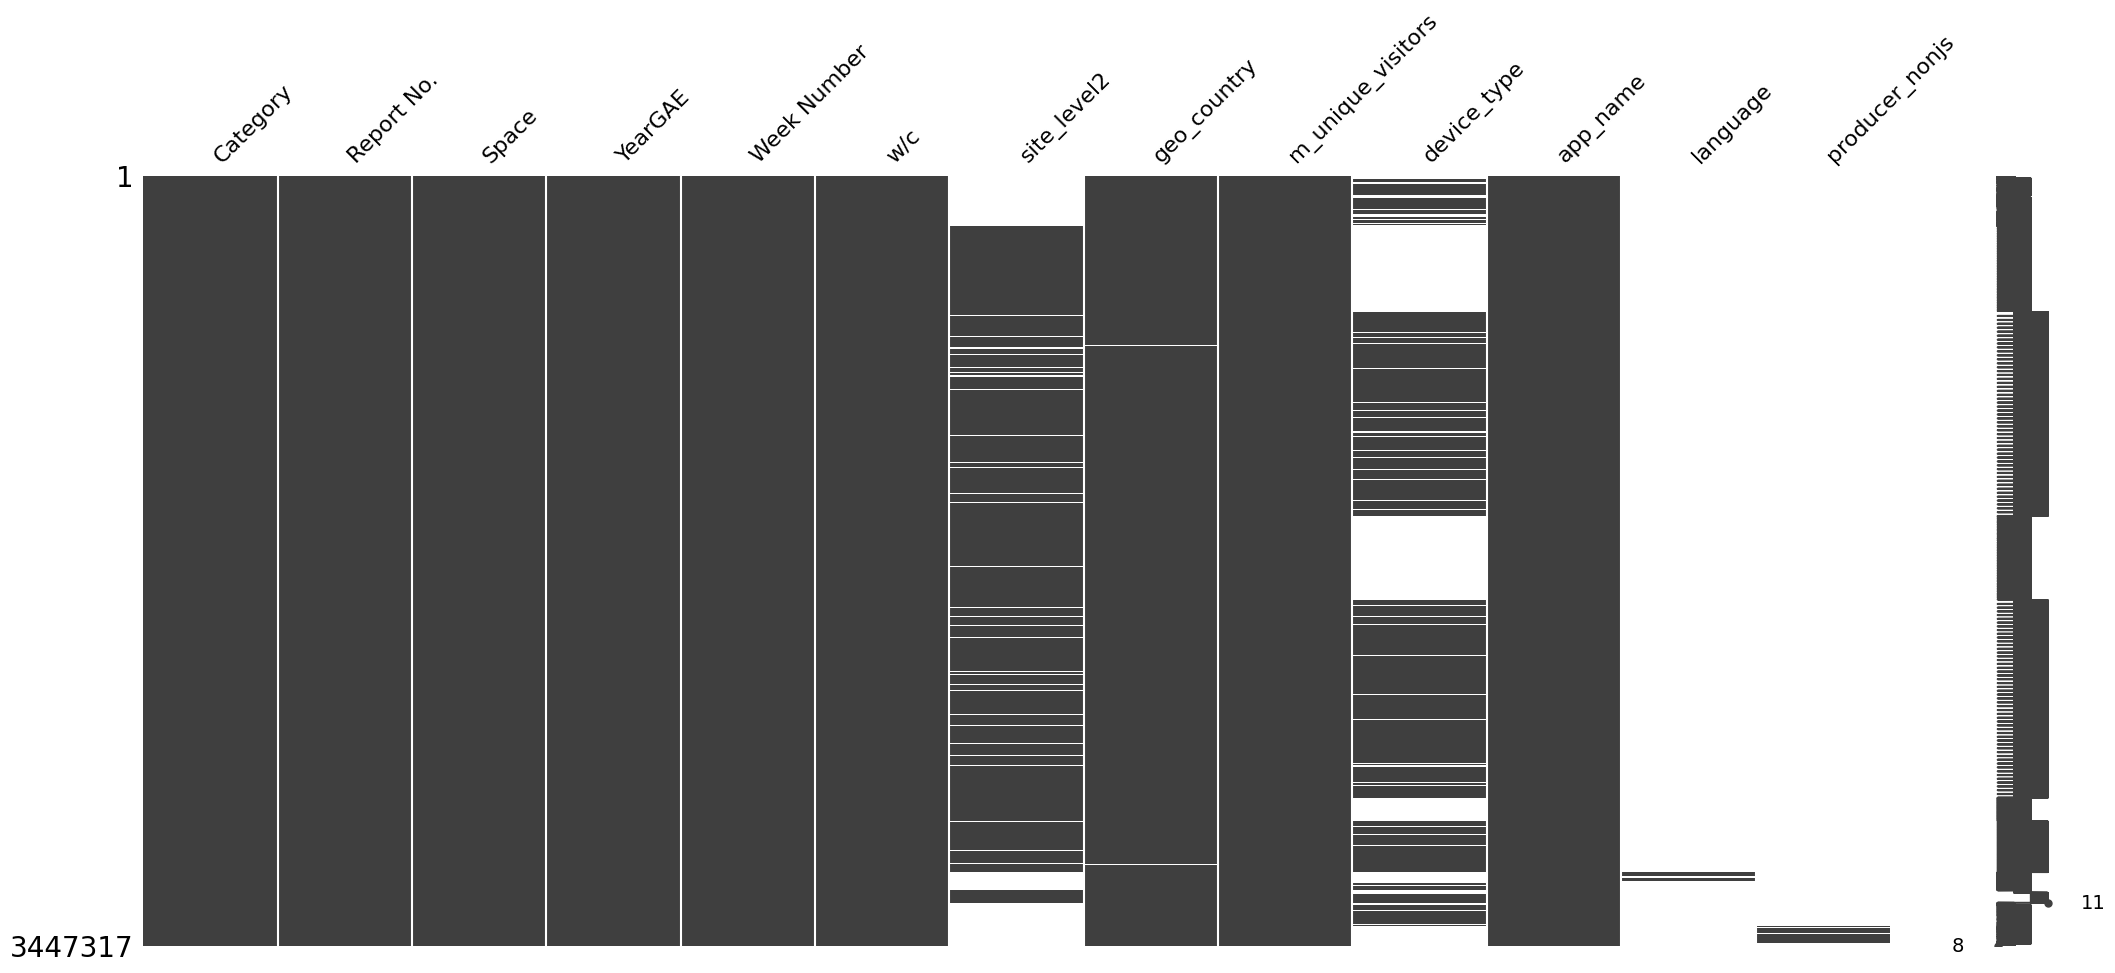

In [6]:
msno.matrix(full_df)

In [7]:
# TO DO somewhere here the column device_type has it's nan values replaced with nan -where and why? 
# TODO add test that ther are more serviceIDs than before after every addition... 
#def test_increased_knownColVals(df, )
print(f"1: {full_df.shape}")

################ ADD SERVICE (& PLATFORM) BASED ON SITE_INFO_SERVICE - report 16 & 17
test_step ='test all spaces from service are in the raw data'
# test all spaces are there 
cols = ['Space', 'ServiceID', 'PlatformID']

# additional rows test
test_functions.test_join_rowCount(full_df, site_info, ['Report No.', 'Space'], '2_site_1', test_step=test_step)

df = full_df.merge(site_info[cols], on=['Space'], how='inner')
display(df.sample())
print(df['Report No.'].unique())
print(f"2: {df.shape}")

################ ADD SERVICE BASED ON SITE_LEVEL2 - report 23
cols = ['ServiceID', 'site_level2']

df['site_level2'] = df['site_level2'].str.lower()
service_codes['site_level2'] = service_codes['site_level2'].str.lower()

test_functions.test_join_rowCount(df[df['ServiceID'].isna() & df['site_level2'].notna() & (df['site_level2'] != '')], 
                               service_codes[cols].dropna(), ['site_level2'], '2_site_2', 
                               'test services are in piano raw data')

df = df.merge(service_codes[cols].dropna(), on='site_level2', how='left', suffixes=('', '_y'))

# Fill missing ServiceID 
df['ServiceID'] = df['ServiceID'].fillna(df['ServiceID_y'])
# Drop the extra columns
df.drop(columns=['ServiceID_y' ], inplace=True)
print(f"3: {df.shape}")

################ ADD SERVICE BASED ON LANGUAGE
cols = ['ServiceID', 'language']
test_functions.test_join_rowCount(df[df['ServiceID'].isna() & df['language'].notna() & (df['language'] != '')], 
                               service_language_map[cols].dropna(), ['language'], '2_site_3', 
                               'test languages are in piano raw data')
# Merge DataFrames to fill missing values
df = df.merge(service_language_map[cols].dropna(), on='language', how='left', 
              suffixes=('', '_y'), indicator=True)

# Fill missing ServiceID 
df['ServiceID'] = df['ServiceID'].fillna(df['ServiceID_y'])
temp_win = df[df['_merge'] == 'both']
temp_www = temp_win.copy()
temp_www['PlatformID'] = 'WWW'
temp = pd.concat([temp_win, temp_www])
temp['ServiceID'] = 'AX2'
df = pd.concat([df[df['_merge'] != 'both'], temp_win, temp_www, temp])

# Drop the extra columns
df.drop(columns=['ServiceID_y', '_merge'], inplace=True)
print(f"4: {df.shape}")

################ ADD SERVICE BASED ON producer nonjs
test_functions.test_join_rowCount(df[df['ServiceID'].isna() & df['producer_nonjs'].notna() & (df['producer_nonjs'] != '')], 
                               non_js_map, ['producer_nonjs'], '2_site_4', 
                               'test producer nonjs are in piano raw data')
# Merge DataFrames to fill missing values
df = df.merge(non_js_map, on='producer_nonjs', how='left', 
              suffixes=('', '_y'), indicator=True)

# Fill missing ServiceID 
df['ServiceID'] = df['ServiceID'].fillna(df['ServiceID_y'])

temp = df[df['_merge'] == 'both']
# ask payam why here exclude GNL & UK
temp = temp[~((temp['ServiceID'] == 'GNL') & (temp['geo_country'] == 'United Kingdom'))]
temp_www = temp.copy()
temp_www['PlatformID'] = 'WWW'
temp_ax2 = pd.concat([temp, temp_www])
temp_ax2['ServiceID'] = 'AX2'
df = pd.concat([df[df['_merge'] != 'both'], temp, temp_www, temp_ax2])

# Drop the extra columns
df.drop(columns=['ServiceID_y', '_merge'], inplace=True)
print(f"5: {df.shape}")

1: (3447317, 13)
join - row count test 2_site_1 successful: No issues found.
...updating logbook...



,Category,Report No.,Space,YearGAE,Week Number,w/c,site_level2,geo_country,m_unique_visitors,device_type,app_name,language,producer_nonjs,ServiceID,PlatformID
1752100,Reach Calc.,20,WSLS-Direct-C,2025,33,2024-08-12,Turkish,Togo,10.0,NaN,nan,NaN,NaN,NaN,WDI


['12' '13' '14' '15' '16' '17' '18' '19' '20' '21' '22' '23' '24' '25'
 '26' '27' '28' '29' '30' '31' '100']
2: (3447317, 15)
join - row count test 2_site_2 successful: No issues found.
...updating logbook...

3: (3447317, 15)
join - row count test 2_site_3 successful: No issues found.
...updating logbook...

4: (3539048, 15)
join - row count test 2_site_4 successful: No issues found.
...updating logbook...

5: (3612383, 15)


In [8]:
df[df['ServiceID'].isna() & df['app_name'].notna() & (df['app_name'] != '')][['Report No.', '']].unique()

array(['18', '19', '20', '21', '22', '23', '24', '31'], dtype=object)

In [ ]:
################ ADD SERVICE BASED ON app_name
test_functions.test_join_rowCount(df[df['ServiceID'].isna() & df['app_name'].notna() & (df['app_name'] != '')], 
                               app_map, ['app_name'], '2_site_5', 
                               'test apps are in piano raw data')
# Merge DataFrames to fill missing values
df = df.merge(app_map[['app_name', 'ServiceID']], on='app_name', how='left',  
              suffixes=('', '_y'), indicator=True)

# Fill missing ServiceID 
df['ServiceID'] = df['ServiceID'].fillna(df['ServiceID_y'])

# ask Payam why here not AX2
temp = df[df['_merge'] == 'both']
temp_www = temp.copy()
df = pd.concat([df[df['_merge'] != 'both'], temp, temp_www])


# Drop the extra columns
df.drop(columns=['ServiceID_y', '_merge'], inplace=True)
print(f"6: {df.shape}")

################ STORE ISSUES
# TODO: go through missing services and see if these can't get a ServiceID
df[df['ServiceID'].isna()].to_excel(f"../test/specific/{gam_info['file_timeinfo']}_site_missingServiceIDs.xlsx")

################ ADD PLACEID
test_step = 'cleaning & adding placeID'
df['geo_country']= df['geo_country'].replace('Europe (unknown country)', 'Unknown')
df['geo_country']= df['geo_country'].fillna('Unknown')

cols = ['PlaceID', 'geo_country']
test_functions.test_inner_join(df, country_codes[cols], ['geo_country'],
                '2_site_6', test_step, focus='left')

test_functions.test_join_rowCount(df, country_codes[cols], ['geo_country'],
                '2_site_7', test_step)

df = df.merge(country_codes[cols], on='geo_country', how='left')

In [ ]:
df['Report No.'].unique()

In [ ]:
################ ADD PLATFORM TO STUDIOS

#where PlatformID is missing and ServiceID = WOR, set PlatformID = WDI
df.loc[df['PlatformID'].isna() & (df['ServiceID'] == 'WOR'), 'PlatformID'] = 'WDI'


In [ ]:
# Specify the dtype option to avoid DtypeWarning for columns with mixed types
dtype_spec = {
    'geo_country': str,
    'device_type': str,
    'PlaceID': str
}

df['m_unique_visitors'] = pd.to_numeric(df['m_unique_visitors'])

# Convert columns to the specified dtypes
for column, dtype in dtype_spec.items():
    if column in df.columns:
        df[column] = df[column].astype(dtype)

drop_list = ['site_level2', 'language', 'producer_nonjs', 'app_name', 'geo_country']
df.drop(columns=drop_list, inplace=True)

############################# TESTING start
main_df = df
test_step = 'final_testig_pianoData'
# test all weeks present
test_functions.test_weeks_presence_per_account('w/c', ['ServiceID'], main_df, week_tester, 
                                               '2_site_8', test_step)

# test placeID in lookup
test_functions.test_inner_join(main_df, country_codes, ['PlaceID'], 
                               '2_site_9', test_step, focus='left')

# test platformID in lookup
test_functions.test_inner_join(main_df, platform_codes, ['PlatformID'], 
                               '2_site_10', test_step, focus='left')

# test serviceID in lookup
test_functions.test_inner_join(main_df, service_codes, ['ServiceID'], 
                               '2_site_11', test_step, focus='left')

############################# TESTING end
msno.matrix(df)
df.to_csv(f"../data/processed/{gam_info['file_timeinfo']}_DataFromPiano.csv", index=None)

In [ ]:
# GLOBAL NEWS PARTNERS 
gnl_data = pd.read_excel(f"../data/raw/site/{gam_info['file_timeinfo']}_GNL_syndication.xlsx", 
                         sheet_name='overview').rename(columns={'Sum of Avg Weekly visitors 2025': 'm_unique_visitors'})
gnl_data = gnl_data.groupby('Country')['m_unique_visitors'].sum().reset_index()
gnl_data = gnl_data[(~gnl_data['Country'].isna()) & (gnl_data['Country']!='United kingdom')
                    & (gnl_data['Country']!='Grand Total')]

# clean countries
country_codes_temp = country_codes[['GNL Syndication', 'PlaceID']].rename(columns={'GNL Syndication': 'Country'})
test_functions.test_inner_join(gnl_data, country_codes_temp, ['Country'], '2_site_12', 'adding syndicated GNL data', focus='left')
gnl_data = gnl_data.merge(country_codes_temp, on='Country', how='inner').drop(columns='Country')

gnl_weekly = gnl_data.merge(week_tester[['YearGAE', 'w/c']], how='cross')

gnl_weekly['ServiceID'] = 'GNL'

gnl_weekly_win = gnl_weekly.copy()
gnl_weekly_win['PlatformID'] = 'WIN'

gnl_weekly_www = gnl_weekly.copy()
gnl_weekly_www['PlatformID'] = 'WWW'
display(gnl_weekly_www.sample())

############################# TESTING start
main_df = pd.concat([gnl_weekly_win, gnl_weekly_www])
test_step = 'final_testig_gnlSyndicationData'
# test all weeks present
test_functions.test_weeks_presence_per_account('w/c', ['ServiceID'], main_df, week_tester, 
                                               '2_site_13', test_step)

# test placeID in lookup
test_functions.test_inner_join(main_df, country_codes, ['PlaceID'], 
                               '2_site_14', test_step, focus='left')

# test platformID in lookup
test_functions.test_inner_join(main_df, platform_codes, ['PlatformID'], 
                               '2_site_15', test_step, focus='left')

# test serviceID in lookup
test_functions.test_inner_join(main_df, service_codes, ['ServiceID'], 
                               '2_site_16', test_step, focus='left')

############################# TESTING end

df_gnl = pd.concat([df, gnl_weekly_win, gnl_weekly_www])


In [ ]:
msno.matrix(df_gnl)

In [ ]:
# LEARNING ENGLISH PARTNERS
cols = ['w/c', 'PlaceID', 'PlatformID', 'ServiceID', 'Reach']
le_partner = pd.read_excel(f"../data/raw/site/{gam_info['file_timeinfo']}_Learning_English_Partners.xlsx", 
                         sheet_name='Weekly Reach')[cols]
le_partner.rename(columns={'Reach': 'm_unique_visitors'}, inplace=True)
le_partner_www = le_partner.copy()
le_partner_www['PlatformID'] = 'WWW'

le_partner = pd.concat([le_partner, le_partner_www])
############################# TESTING start
main_df = le_partner
test_step = 'final_testig_lePartners'

# test all weeks present
test_functions.test_weeks_presence_per_account('w/c', ['ServiceID'], main_df, week_tester, 
                                               '2_site_17', test_step)

# test placeID in lookup
test_functions.test_inner_join(main_df, country_codes, ['PlaceID'], 
                               '2_site_18', test_step, focus='left')

# test platformID in lookup
test_functions.test_inner_join(main_df, platform_codes, ['PlatformID'], 
                               '2_site_19', test_step, focus='left')

# test serviceID in lookup
test_functions.test_inner_join(main_df, service_codes, ['ServiceID'], 
                               '2_site_20', test_step, focus='left')

############################# TESTING end
df_gnl_le = pd.concat([df_gnl, le_partner])

In [ ]:
msno.matrix(df_gnl_le)

In [ ]:
cols = ['Space', 'YearGAE', 'w/c', 'm_unique_visitors', 'device_type', 'ServiceID', 'PlatformID', 'PlaceID']
df_gnl_le[cols].to_csv(f"../data/processed/{gam_info['file_timeinfo']}_SiteData.csv", index=None)

In [ ]:
df_gnl_le['Report No.'].unique()